In [1]:
import sys,os
import numpy as np
import ROOT
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

Welcome to JupyROOT 6.20/06


In [2]:
ROOT.gSystem.Load(os.path.abspath("../Delphes/libDelphes.so"))

0

In [3]:
try:
    ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

In [6]:
inputFile = '../data/chargino_6e-16_300.root'

# Create chain of root trees
chain = ROOT.TChain("Delphes")
chain.Add(inputFile)

# Create object of class ExRootTreeReader
treeReader = ROOT.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

In [7]:
# Get pointers to branches used in this analysis
particles = treeReader.UseBranch("Particle")

In [16]:
# %% Loop over all events
RDV = []
DV = []
TOF = []
for entry in range(0, numberOfEntries):
    # Load selected branches with data from specified event
    treeReader.ReadEntry(entry)

    for iptc in range(0,particles.GetEntries()):
        particle = particles.At(iptc)
        if particle.Mass < 100.0 or abs(particle.PID) < 1000:
            continue

        #Get daughters
        daughters = [particles.At(idaughter) for idaughter in range(particle.D1,particle.D2+1)]
        #Skip cases in which daughter is the same as mother (intermediate state)
        if any([d.PID == particle.PID for d in daughters]):
            continue

        #Compute the production vertex for the daughter (= decay vertex)
        r = [np.sqrt(d.X**2 + d.Y**2 + d.Z**2) for d in daughters]
        
        tof = [d.T for d in daughters]
        if np.std(r)/np.mean(r) > 0.01:
            print('Daughters do not come from the same vertex. Skipping')
            print(r)
        else:
            DV.append(np.mean(r))
        if np.std(tof)/np.mean(tof) < 0.01:
            TOF.append(np.mean(tof))

In [9]:
@np.vectorize
def n0(r,width):
    """
    :param r: distance (in mm)
    """
    
    ctau = 1.967e-13/width #c*tau in mm
    return np.exp(-r/ctau)/ctau

In [10]:
rpts = np.linspace(0,3000,1000)
npts = n0(rpts,width = 6.582e-16)

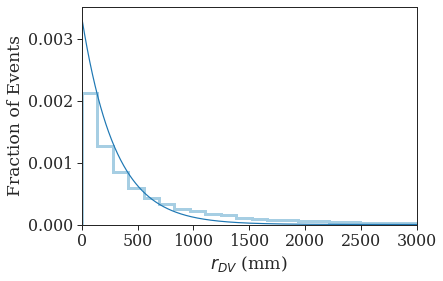

In [11]:
plt.hist(DV,bins=100,density=True,histtype='step',linewidth=3)
plt.plot(rpts,npts)
plt.xlabel(r'$r_{DV}$ (mm)')
plt.ylabel('Fraction of Events')
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0,3000)
# plt.ylim(1e-10,1e-2)
plt.show()

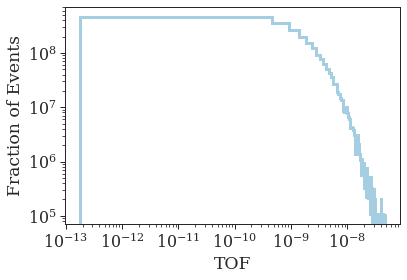

In [18]:
plt.hist(TOF,bins=100,density=True,histtype='step',linewidth=3)
plt.xlabel('TOF')
plt.ylabel('Fraction of Events')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0,3000)
# plt.ylim(1e-10,1e-2)
plt.show()